In [1]:
import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

import scipy.optimize as spopt
from scipy.stats import pearsonr

from logistic_regression_helpers import *


Using TensorFlow backend.


<h2>Load 5' Alternative Splicing Data</h2>

- Load a Pandas DataFrame + Matlab Matrix of measured Splicing Sequences<br/>
- isolearn.io loads all .csv and .mat files of a directory into memory as a dictionary<br/>
- The DataFrame has one column - padded_sequence - containing the splice donor sequence<br/>
- The Matrix contains RNA-Seq counts of measured splicing at each position across the sequence<br/>


In [2]:
#Load Splicing Data

splicing_dict = isoio.load('data/processed_data/splicing_5ss_data/splicing_5ss_data')


<h2>Create a Training and Test Set</h2>

- We create an index containing row numbers corresponding to training and test sequences<br/>
- Notice that we do not alter the underlying DataFrame, we only make lists of pointers to rows<br/>


In [3]:
#Generate training and test set indexes

test_set_size = 0.10

data_index = np.arange(len(splicing_dict['df']), dtype=np.int)

train_index = data_index[:-int(len(data_index) * test_set_size)]
test_index = data_index[train_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))

Training set size = 238183
Test set size = 26464


<h2>Create Data Generators</h2>

- In Isolearn, we always build data generators that will encode and feed us the data on the fly<br/>
- Here, for example, we create a training and test generator separately (using list comprehension)<br/>
- First argument: The list of row indices (of data points) for this generator<br/>
- Second argument: Dictionary or data sources<br/>
- Third argument: Batch size for the data generator
- Fourth argument: List of inputs, where each input is specified as a dictionary of attributes<br/>
- Fifth argument: List of outputs<br/>

In this example, we specify slightly more complicated inputs and outputs:<br/>
- We specicy two different inputs: Two hexamer encoders (NMerEncoders) for two different parts of the splice donor sequence<br/>
- We also use list comprehension to specify 4 different Splice Donor Usage targets (outputs), one for each cell line<br/>


In [4]:
#Create a hexamer count data generator, to be used for logistic regression of SD1 Usage (HEK cell line)
#Set the batch sizes equal to the size of the train/test sets.

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : splicing_dict['df'],
            'hek_count' : splicing_dict['hek_count'],
            'hela_count' : splicing_dict['hela_count'],
            'mcf7_count' : splicing_dict['mcf7_count'],
            'cho_count' : splicing_dict['cho_count'],
        },
        batch_size=len(idx),
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_sequence'][122: 122 + 35],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_sequence'][165: 165+35],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : lambda c, index: np.ravel(c),
                'transformer' : lambda t: t[120] / np.sum(t)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('test', test_index)]
}


<h2>Execute the data generators by indexing them</h2>

In this example, we specified the batch size to be the entire train/test sets.<br/>
Hence, indexing into the generators at index 0 gives us the entire encoded dataset.


In [5]:
#Get training data from generator
[X_up_train, X_dn_train], [y_train_hek, y_train_hela, y_train_mcf7, y_train_cho] = splicing_gens['train'][0]
X_train = sp.hstack([X_up_train, X_dn_train])

#Get test data from generator
[X_up_test, X_dn_test], [y_test_hek, y_test_hela, y_test_mcf7, y_test_cho] = splicing_gens['test'][0]
X_test = sp.hstack([X_up_test, X_dn_test])
 

<h2>Perform Logistic Hexamer Regression</h2>

Here we take our X and y matrices and feed them into an optimization algorithm (LM-BFGS with Logistic Regression) in order to learn log odds ratio weights of each of the hexamer counts encoded in matrix X, on the basis of how they influence splice donor usage (y).


Starting logistic n-mer regression for cell line hek...
Regression finished.
Test set R^2 = 0.78, p = 0.0


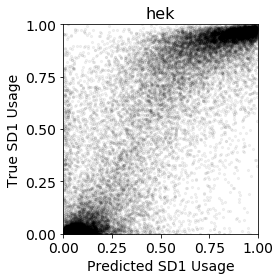

Starting logistic n-mer regression for cell line hela...
Regression finished.
Test set R^2 = 0.79, p = 0.0


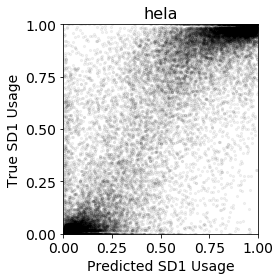

Starting logistic n-mer regression for cell line mcf7...
Regression finished.
Test set R^2 = 0.77, p = 0.0


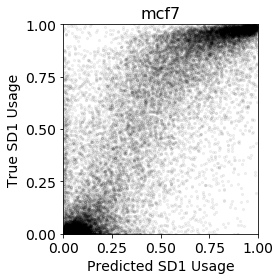

Starting logistic n-mer regression for cell line cho...
Regression finished.
Test set R^2 = 0.8, p = 0.0


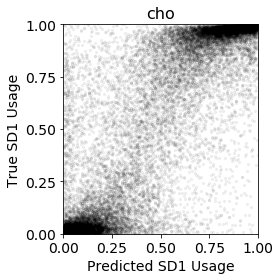

In [6]:
#Perform hexamer logistic regression on all cell lines

cell_lines = [
    ('hek', (y_train_hek, y_test_hek)),
    ('hela', (y_train_hela, y_test_hela)),
    ('mcf7', (y_train_mcf7, y_test_mcf7)),
    ('cho', (y_train_cho, y_test_cho))
]

for cell_name, [y_train, y_test] in cell_lines :
    
    print("Starting logistic n-mer regression for cell line " + str(cell_name) + "...")

    w_init = np.zeros(X_train.shape[1] + 1)
    lambda_penalty = 0

    (w_bundle, _, _) = spopt.fmin_l_bfgs_b(log_loss, w_init, fprime=log_loss_gradient, args=(X_train, y_train, lambda_penalty), maxiter = 200)

    print("Regression finished.")
    
    #Collect weights
    w = w_bundle[1:]
    w_0 = w_bundle[0]

    #Evaluate predictions on test set
    y_test_pred = get_y_pred(X_test, w, w_0)
    
    r_val, p_val = pearsonr(y_test_pred, y_test)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    #Plot test set scatter
    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_test_pred, y_test, color='black', s=5, alpha=0.05)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Predicted SD1 Usage', fontsize=14)
    plt.ylabel('True SD1 Usage', fontsize=14)
    plt.title(str(cell_name), fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
